In [13]:
import os
import textract
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize

from collections import Counter
from collections import defaultdict

In [14]:
resume_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/Selected/'
jd_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/'
reference = '/Users/Ketki/Documents/MS Theses/Candidate list.xlsx'
fig_path = '/Users/Ketki/Documents/MS Theses/Reference Papers and Data/Fig/'

In [15]:
def preprocessText(text, textEncoding = 'windows-1252'):
    text = re.sub(r'[^\x20-\x7e]',r' ', text.decode(encoding = textEncoding))
    return text

In [16]:
def getResumeReference(referencePath):
    refDataFrame = pd.read_excel(reference)
    return refDataFrame

In [17]:
def getResumeDataFrame(resumePath):
    resume_list = []
    r_file_list = []
    
    for file in os.listdir(resume_path):
        if file == '.DS_Store':
            continue
            
        filename = resume_path + file
        #print(filename)
        r_file_list.append(file)
        
        try:
            text = textract.process(filename)
            text = preprocessText(text, 'utf-8')
            resume_list.append(text)
        except Exception as se:
            print('{} -> {}'.format(file, se))
            
    resumeDataFrame = pd.DataFrame(list(zip(r_file_list,resume_list)), \
                             columns = ['res_name','res_contents'])
    refDataFrame = getResumeReference(reference)
    
    resumeDataFrame = resumeDataFrame.join(refDataFrame.set_index('res_name'),\
                                           on = 'res_name')
    
    return resumeDataFrame

In [18]:
def getJobNationality(jobFile):
    reNation = re.search('jd_([a-z]*)[0-9]*.*', jobFile, re.IGNORECASE)
    if reNation:
        nationality = reNation.group(1)
    else:
        raise 'Unknown JD Nationality'
        
    return nationality

In [19]:
def getJobDescription(jobFile, JDname):
    jobTitle = 'input'
    jobName = 'JDname'
    nationality = getJobNationality(jobFile)
    jobText = textract.process(jobFile)
    jobText = preprocessText(jobText, 'utf-8')
    return {'res_name': jobTitle, 
            'res_contents': jobText, 
            'name': jobName, 
            'nationality':  nationality}

def TFIDF(processDataFrame):
    
    tfidf = TfidfVectorizer(stop_words = 'english', lowercase = True)
    tfidfMatrix = tfidf.fit_transform(processDataFrame['res_contents'])
    
    # Normalize the tf-idf vectors
    tfidfMatrix = normalize(tfidfMatrix)
    
    cosine_sim = linear_kernel(tfidfMatrix, tfidfMatrix)
    indices = pd.Series(processDataFrame.index, \
                        index=processDataFrame['res_name']).drop_duplicates()
    
    idx = indices['input']
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    
    resume_indices = [i[0] for i in sim_scores]
    selectedResumes = processDataFrame.iloc[resume_indices]

    
    return (tfidfMatrix, selectedResumes, sim_scores)

def getKMeans(processDataFrame, tfidfMatrix):
    k = 3
    km = KMeans(n_clusters = k,init = 'random', max_iter = 250, \
                n_init = 15, random_state = 100)
    y_km = km.fit_predict(tfidfMatrix)
    centroids = km.cluster_centers_


    km_result = pd.DataFrame(km.labels_)
    km_validate = pd.concat([processDataFrame['nationality'],km_result], axis = 1) 
    print(km_validate)
    
    return km

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
def BOW(processDataFrame):
    bow = CountVectorizer(stop_words = 'english',lowercase = True)
    bowMatrix = bow.fit_transform(processDataFrame['res_contents'])
    # Normalize the bow vectors
    bowMatrix = normalize(bowMatrix)
    cosine_sim = linear_kernel(bowMatrix, bowMatrix)
    indices = pd.Series(processDataFrame.index, \
                        index=processDataFrame['res_name']).drop_duplicates()
    
    idx = indices['input']
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    
    resume_indices = [i[0] for i in sim_scores]
    selectedResumes = processDataFrame.iloc[resume_indices]
    print(selectedResumes)
    print(sim_scores)

    
    return (bowMatrix, selectedResumes, sim_scores)

In [21]:
def getTSNE(bowMatrix):
    k = 30
    svd_matrix = TruncatedSVD(n_components = k, \
                              random_state = 0).fit_transform(bowMatrix)


    t_sne = TSNE(perplexity = 12, \
                 verbose = 2, \
                 learning_rate = 200).fit_transform(svd_matrix)
    return t_sne

In [27]:
def plot(processDataFrame, t_sne, JDname,fig_path):
    fig = plt.figure(figsize = (10,10))
    plotData = {}
    for i in range(0, t_sne.shape[0]):
        if processDataFrame['res_name'][i] == 'input':
            scatter = plt.scatter(t_sne[i,0],t_sne[i,1],c='black', s=100, marker='s', \
                        label='jd: %s'.format(processDataFrame['nationality'][i]))
#            slabel = 'jd : {}'.format(processDataFrame['nationality'][i])
#            plt.scatter(t_sne[i,0], t_sne[i,1], c='black', s=200, marker = 's', \
#                        label=slabel)
            pass
        elif processDataFrame['nationality'][i] == 'India':
            #scatter = plt.scatter(t_sne[i,0],t_sne[i,1],c='r', marker='+', \
            #                 label = 'resume : India (Red)')
            if 'India' in plotData:
                plotData['India']['X'].append(t_sne[i,0])
                plotData['India']['Y'].append(t_sne[i,1])
            else:
                plotData['India'] = {}
                plotData['India']['X'] = list([t_sne[i,0]])
                plotData['India']['Y'] = list([t_sne[i,1]])
        elif processDataFrame['nationality'][i] == 'Malaysia':
            #scatter = plt.scatter(t_sne[i,0],t_sne[i,1],c='g', marker='o', \
            #                 label = 'resume : Malaysia (Green)')
            if 'Malaysia' in plotData:
                plotData['Malaysia']['X'].append(t_sne[i,0])
                plotData['Malaysia']['Y'].append(t_sne[i,1])
            else:
                plotData['Malaysia'] = {}
                plotData['Malaysia']['X'] = list([t_sne[i,0]])
                plotData['Malaysia']['Y'] = list([t_sne[i,1]])
        elif processDataFrame['nationality'][i] == 'China':    
            #scatter = plt.scatter(t_sne[i,0],t_sne[i,1],c='b', marker='*', \
            #                 label = 'resume : China (Blue)'
            if 'China' in plotData:
                plotData['China']['X'].append(t_sne[i,0])
                plotData['China']['Y'].append(t_sne[i,1])
            else:
                plotData['China'] = {}
                plotData['China']['X'] = list([t_sne[i,0]])
                plotData['China']['Y'] = list([t_sne[i,1]])
    
    
    for key in plotData.keys():
        if key == 'India':
            slabel = 'resume : India'
            sc = 'r'
            sm = '+'
        elif key == 'China':
            slabel = 'resume : China'
            sc = 'b'
            sm = '*'
        elif key == 'Malaysia':
            slabel = 'resume : Malaysia'
            sc = 'g'
            sm = 'o'
            
        scatter = plt.scatter(plotData[key]['X'], plotData[key]['Y'], \
                              c = sc, marker = sm, \
                              label = slabel)

    plt.legend()    
    plt.grid()
    plt.show()  
#    figName = fig_path + JDname + '.png'
#    plt.savefig(figName)

In [25]:
distributionMatrix = {}
def processJobDescription(resumePath, jobFile, JDname, fig_path):
    
    resumeDataFrame = getResumeDataFrame(resumePath)
    jobDescription = getJobDescription(jobFile, JDname)
    processDataFrame = resumeDataFrame.append(jobDescription, \
                                              ignore_index = True)
    processDataFrame = processDataFrame.dropna()
    
    
    bowMatrix, selectedResumes, sim_scores = BOW(processDataFrame)
    
    distribution = Counter(selectedResumes['nationality'])
    print(distribution)

    jobNationality = jobDescription['nationality']
    if jobNationality in distributionMatrix:
        distributionMatrix[jobNationality]['total'] += 1
        
    else:
        distributionMatrix[jobNationality] = defaultdict(int)
        distributionMatrix[jobNationality]['total'] += 1
    
    for key in distribution.keys():
        distributionMatrix[jobNationality][key] += distribution[key]
    
#    kMeans = getKMeans(processDataFrame, tfidfMatrix)
    tsne = getTSNE(bowMatrix)
    plot(processDataFrame, tsne, JDname,fig_path)

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_malaysia.docx
                                          res_name  \
56   Sunrise_Anusha Shashidhar_Pricing Finance.pdf   
121               JTB_Chung Yon Jie_Accountant.pdf   
81                 SMBC_Kerry Chin_Regional IA.pdf   
44                 PWC_Chuah Ying Sze_Audit AM.pdf   
131                HP_Adrian Hew_Acc Team Lead.pdf   
39                    Muhibbah_Abdul Rahman_FM.doc   
76           Sinowealth_Tan Sze Nee_Accountant.pdf   
114          KPMG_Lee Tze Choong_Audit Manager.pdf   
74      Pos Logistics_Norashra Omar_Finance VP.pdf   
37                KC Chan_Teh Yee Chun_Auditor.pdf   

                                          res_contents  \
56   Resume Internal Audit Professional fa  Anusha ...   
121  CHUNG YON JIE RESUME  01.08.2017  Ms. CHUNG YO...   
81   RESUME KERRY CHIN CPA (Australia), CAMS, CA (S...   
44   Chuah Ying Sze Contact Info : Blk 151 Riverval...   
131  Adrian Hew Weng Choong Blk 304,

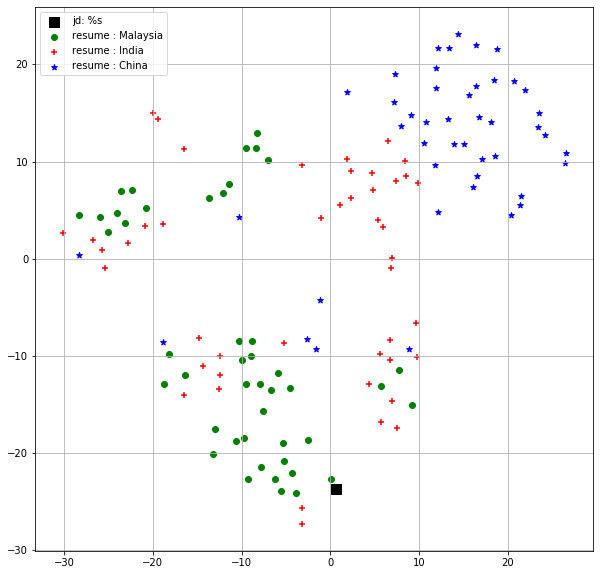

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_malaysia1.docx
                                              res_name  \
64                       Super FI_Kho Teck Ghim_FM.pdf   
116           Red Money_Faizah Hassan_Finance Head.pdf   
39                        Muhibbah_Abdul Rahman_FM.doc   
126                     Oracle_Deepa Natarajan_FC.docx   
17                      Maples_Kasturi Majumdar_VP.pdf   
99              Tour East_Vanessa Chiam_Finance AM.pdf   
19                      Jirnexu_ATIFAH ISHAK_Sr FM.pdf   
103           Goldman_Santosh Suresh_Onboarding TM.pdf   
60   Schlumberger_Yogesvaran Saithu_Mgmt Accountant...   
134                       Six Capital_MANJUNATH_FM.doc   

                                          res_contents                  name  \
64   Kho Teck Ghim   Qualified Chartered Accountant...        Kho Teck Ghim    
116  Name: FAIZAH BINTI HASSAN Contact No : 012-221...   Faizah Binti Hassan   
39                                       

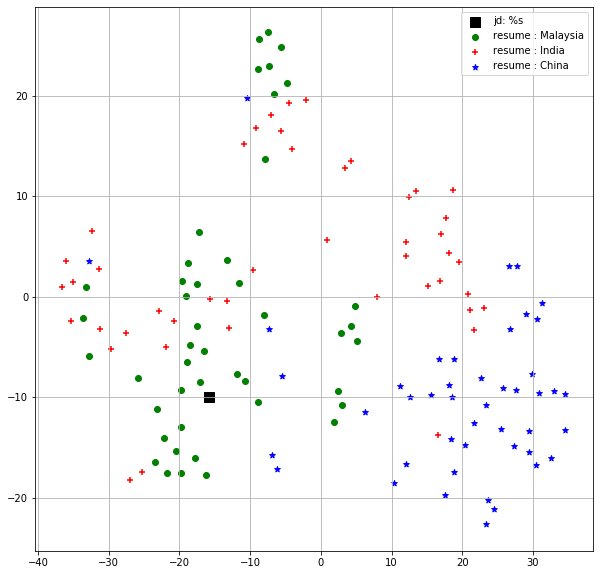

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_india2.docx
                                              res_name  \
125                    EY_Helena He_Senior Auditor.pdf   
17                      Maples_Kasturi Majumdar_VP.pdf   
20          PE Firm_Arun Kumar_Investment Advisory.pdf   
60   Schlumberger_Yogesvaran Saithu_Mgmt Accountant...   
102  Apex Fund Svcs_Monali Hirawat_Financial Accoun...   
8    Aglaia IM_Subhashini Gurumurthy_Sr Investment ...   
39                        Muhibbah_Abdul Rahman_FM.doc   
94         Maybank AM_Varun Rao_Investment Analyst.doc   
14   Probiz Capital_Fasiha Shaikh_BD Investment Dir...   
130       Moody's_Huijuan Luo_Equity Reserarch AVP.pdf   

                                          res_contents                  name  \
125  HELENA HE, AICPA Cell: +852 6213 0822  Email: ...             Halena He   
17   KASTURI MAJUMDAR Tel: + 65 82842308 Email: kas...      Kasturi Majumdar   
20   ARUN KUMAR Dubai / New York|+971 529 77

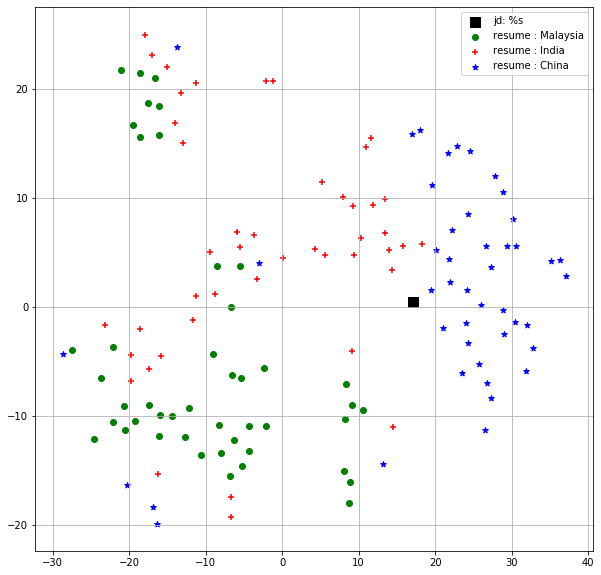

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_india.docx
                                              res_name  \
56       Sunrise_Anusha Shashidhar_Pricing Finance.pdf   
121                   JTB_Chung Yon Jie_Accountant.pdf   
81                     SMBC_Kerry Chin_Regional IA.pdf   
131                    HP_Adrian Hew_Acc Team Lead.pdf   
79      Rasmala IB_Saba Tirpathur_Compliance Asst.docx   
39                        Muhibbah_Abdul Rahman_FM.doc   
76               Sinowealth_Tan Sze Nee_Accountant.pdf   
44                     PWC_Chuah Ying Sze_Audit AM.pdf   
114              KPMG_Lee Tze Choong_Audit Manager.pdf   
1    State Street_Bothini Navaneethan_REIT Officer.pdf   

                                          res_contents  \
56   Resume Internal Audit Professional fa  Anusha ...   
121  CHUNG YON JIE RESUME  01.08.2017  Ms. CHUNG YO...   
81   RESUME KERRY CHIN CPA (Australia), CAMS, CA (S...   
131  Adrian Hew Weng Choong Blk 304, #04-49, Canber..

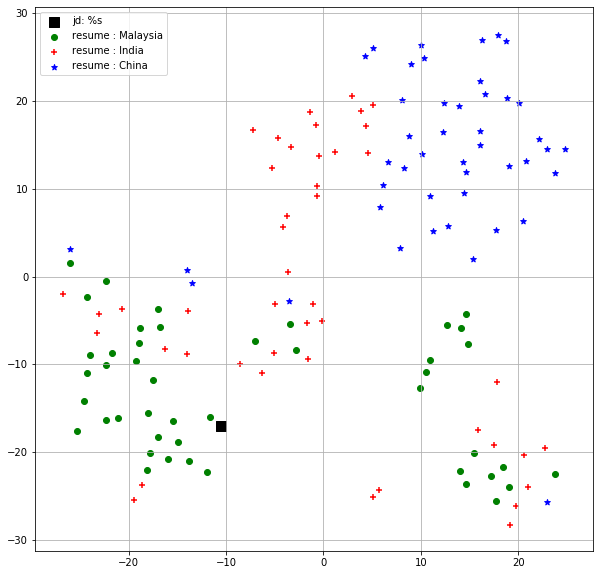

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_china1.docx
                                              res_name  \
98                        FAC_Evon Cheong_Acc Exec.pdf   
9              Oasis_Kishore S_Fund Acc Mgr_Hedge.docx   
39                        Muhibbah_Abdul Rahman_FM.doc   
57      Silverdale_Avinash Kothari_Senior Manager.docx   
18            Newedge_Yashodha N_Brokerage Analyst.pdf   
61                  Pro 1 Mgmt_Bea Boon Ping_Cosec.pdf   
65                    Ward Ferry_Anne Leung_Ops AM.pdf   
92   Sunrise Brokers_Tim Huang_Equity Research Anal...   
134                       Six Capital_MANJUNATH_FM.doc   
17                      Maples_Kasturi Majumdar_VP.pdf   

                                          res_contents                  name  \
98   CURRICULUM VITAE Cheong Yee Wen (Evon) Date of...        Cheong Yee Wen   
9    KISHORE S       PROFESSIONAL SUMMARY  With aro...            Kishore S    
39                                          

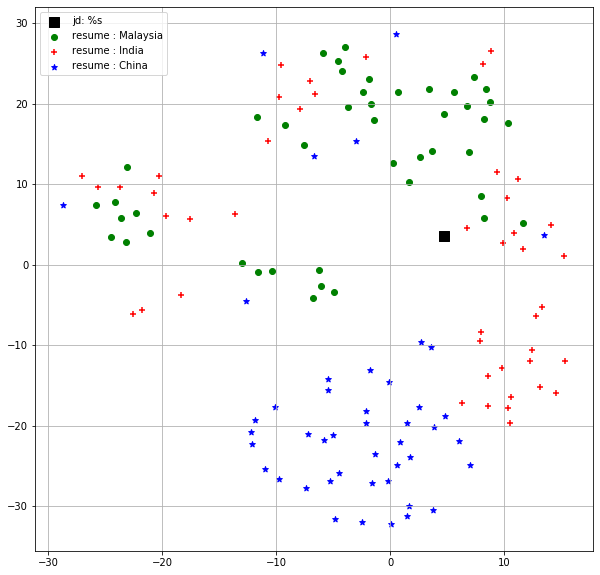

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_india1.docx
                                              res_name  \
49   Evalueserve_SHRIMALI Shipra_Sr Equity Research...   
64                       Super FI_Kho Teck Ghim_FM.pdf   
116           Red Money_Faizah Hassan_Finance Head.pdf   
33                 Mohan Mgmt_Divya Kanth_Sr Cosec.doc   
50                       Iyer_Kinjal Shah_Sr Cosec.doc   
12           Raffles Group_Garima Gupta_Cosec Exec.doc   
118  Supreme Build_Satpreet Kaur_Company Secretary....   
38       Unicorn_Pratik Vora_Global Equity Analyst.pdf   
122                     Xander_Rohit Khandelwal_VP.pdf   
126                     Oracle_Deepa Natarajan_FC.docx   

                                          res_contents                  name  \
49   SHRIMALI, Shipra PROFESSIONAL EXPERIENCE Evalu...       Shrimali Shipra   
64   Kho Teck Ghim   Qualified Chartered Accountant...        Kho Teck Ghim    
116  Name: FAIZAH BINTI HASSAN Contact No : 

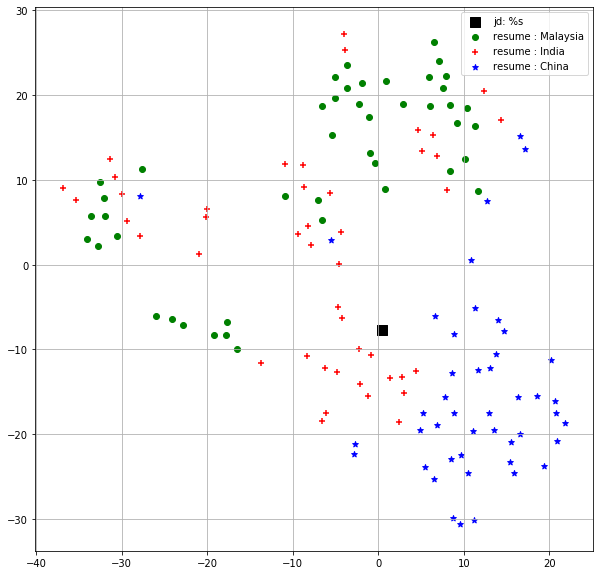

/Users/Ketki/Documents/MS Theses/Reference Papers and Data/JD/jd_china.docx
                                              res_name  \
131                    HP_Adrian Hew_Acc Team Lead.pdf   
81                     SMBC_Kerry Chin_Regional IA.pdf   
37                    KC Chan_Teh Yee Chun_Auditor.pdf   
114              KPMG_Lee Tze Choong_Audit Manager.pdf   
44                     PWC_Chuah Ying Sze_Audit AM.pdf   
76               Sinowealth_Tan Sze Nee_Accountant.pdf   
56       Sunrise_Anusha Shashidhar_Pricing Finance.pdf   
121                   JTB_Chung Yon Jie_Accountant.pdf   
110                               KPMG_Allan Ku_AM.pdf   
1    State Street_Bothini Navaneethan_REIT Officer.pdf   

                                          res_contents  \
131  Adrian Hew Weng Choong Blk 304, #04-49, Canber...   
81   RESUME KERRY CHIN CPA (Australia), CAMS, CA (S...   
37   PERSONAL PARTICULAR Name Correspondence Addres...   
114  Personal Particulars Name Residential address ..

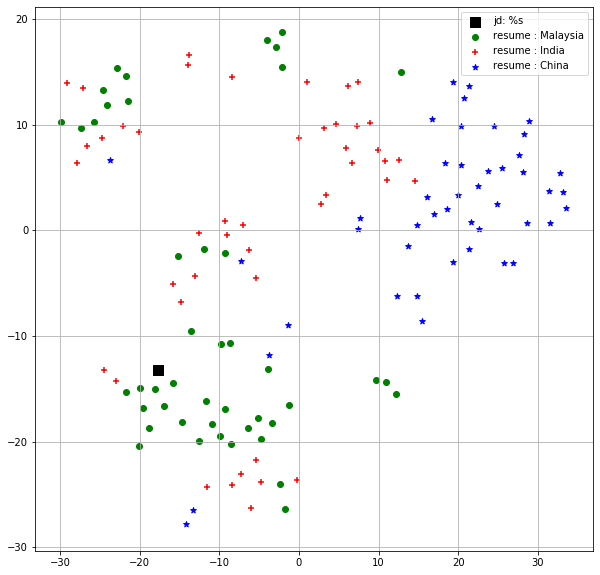

{'malaysia': defaultdict(<class 'int'>, {'total': 6, 'India': 15, 'Malaysia': 45}), 'india': defaultdict(<class 'int'>, {'total': 9, 'China': 6, 'India': 48, 'Malaysia': 36}), 'china': defaultdict(<class 'int'>, {'total': 6, 'Malaysia': 36, 'India': 18, 'China': 6})}


In [30]:
if __name__ == '__main__':
    
    for file in os.listdir(jd_path):
        if file == '.DS_Store':
            continue
            
        filename = jd_path + file
        print(filename)
        processJobDescription(resume_path, filename, file, fig_path)

    print(distributionMatrix)